In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
### PREPROCESSING (Only alphabets, only flex sensors)
## Unzip dataset in same dir as .py gile
labels = [i for i in "abcdefghijklmnopqrstuvwxyz"]

frames = []
for i in range(1,26):
    for j in range(26):
        df = pd.read_csv(f"/content/drive/MyDrive/ASL-Sensor-Dataglove-Dataset/{i:03}/{labels[j]}.csv")
        df = df[["flex_1","flex_2","flex_3","flex_4","flex_5"]]
        df["outcome"] = j
        frames.append(df)
data = pd.concat(frames, axis=0, ignore_index=True)


print(data.head())
X = data[data.columns[:-1]].values
y = data[data.columns[-1]].values

<ipython-input-7-78683dee0fff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outcome"] = j


   flex_1  flex_2  flex_3  flex_4  flex_5  outcome
0    20.0    58.0    72.0    77.0    58.0        0
1    20.0    58.0    70.0    76.0    58.0        0
2    20.0    58.0    73.0    75.0    60.0        0
3    19.0    58.0    73.0    79.0    58.0        0
4     3.0    58.0    72.0    80.0    58.0        0


In [ ]:
#Spliting dataset into test, validation and testing subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [ ]:
#Layer composition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_dim = 5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation="softmax")
])

In [ ]:
#Configuration
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
#Training
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)


Epoch 1/20
18282/18282 [==============================] - 58s 3ms/step - loss: 0.7768 - accuracy: 0.7063 - val_loss: 0.6222 - val_accuracy: 0.7697
Epoch 2/20
18282/18282 [==============================] - 50s 3ms/step - loss: 0.5578 - accuracy: 0.7986 - val_loss: 0.5211 - val_accuracy: 0.8232
Epoch 3/20
18282/18282 [==============================] - 52s 3ms/step - loss: 0.5021 - accuracy: 0.8277 - val_loss: 0.4799 - val_accuracy: 0.8425
Epoch 4/20
18282/18282 [==============================] - 47s 3ms/step - loss: 0.4737 - accuracy: 0.8413 - val_loss: 0.4640 - val_accuracy: 0.8429
Epoch 5/20
18282/18282 [==============================] - 52s 3ms/step - loss: 0.4555 - accuracy: 0.8512 - val_loss: 0.4870 - val_accuracy: 0.8379
Epoch 6/20
18282/18282 [==============================] - 52s 3ms/step - loss: 0.4458 - accuracy: 0.8566 - val_loss: 0.4565 - val_accuracy: 0.8588
Epoch 7/20
18282/18282 [==============================] - 54s 3ms/step - loss: 0.4358 - accuracy: 0.8621 - val_loss: 0

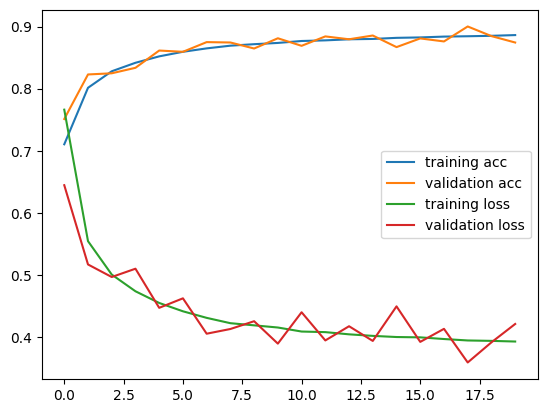

In [ ]:
#Plotting data
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="validation acc")
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

In [ ]:
#predict
flex1_value = -26;
flex2_value = -20;
flex3_value = 41
flex4_value = 32
flex5_value = 40

new_data = np.array([[flex1_value, flex2_value, flex3_value, flex4_value, flex5_value]])
prediction = model.predict(new_data)
print(new_data);

predicted_class_index = np.argmax(prediction)
predicted_letter = labels[predicted_class_index]
print("Predicted ASL sign: ")
print(predicted_letter)
print(X_train.dtype)

1/1 [==============================] - 0s 78ms/step
[[-26 -20  41  32  40]]
Predicted ASL sign: 
x
float64


In [ ]:
#convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
asl_training_model = converter.convert()
asl_training_model_name = "asl_training_model"

open(asl_training_model_name + '.tflite', 'wb').write(asl_training_model)

8560

In [ ]:
#predict tflite
interpreter = tf.lite.Interpreter(model_path = "asl_training_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

flex1_value = -26
flex2_value = -20
flex3_value = 41
flex4_value = 32
flex5_value = 40

new_data = np.array([[flex1_value, flex2_value, flex3_value, flex4_value, flex5_value]], dtype=input_details[0]['dtype'])

interpreter.set_tensor(input_details[0]['index'], new_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

predicted_class_index = np.argmax(output_data)
predicted_letter = labels[predicted_class_index]
print("Predicted class letter:", predicted_letter)


[[5.6903677e-24 0.0000000e+00 7.6228254e-08 1.5499268e-08 0.0000000e+00
  0.0000000e+00 2.0232042e-03 0.0000000e+00 0.0000000e+00 3.0664656e-38
  0.0000000e+00 2.0261189e-01 2.0043827e-14 3.9294675e-11 4.1083103e-30
  1.5801027e-25 1.4308318e-01 0.0000000e+00 1.3230165e-07 2.0883146e-05
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.5216511e-01 5.8671822e-35
  9.5445612e-05]]
Predicted class letter: x


In [ ]:
input_layer = model.input
input_shape = input_layer.shape
print(input_shape)

(None, 5)


In [ ]:
!pip install tinymlgen

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2226 sha256=52103cc8dbe04790f4aa6cac4d54c13c7cc53073981d357265c05f46bdd6bcd5
  Stored in directory: /root/.cache/pip/wheels/37/f6/60/b245c012a863872e10d737539c1e3f2db0499dfb6735f48494
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8896 sha256=901eeca397500dc61f931ec67ba93de9e00fb2b39f1b24fd3d38bd10f05f1724
  Stored in directory: /root/.cache/pip/wheels/26/28/f7/f47d7ecd9ae44c4457e72c8bb617ef18ab332ee2b2a1047e87
Successfully built tinymlgen hexdump


In [ ]:
from tinymlgen import port
#convert model into C array

c_code = port(model, pretty_print=True)
print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 
	0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
	0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x64, 0x1b, 0x00, 0x00, 
	0x74, 0x1b, 0x00, 0x00, 0xec, 0x20, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 
	0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00, 
	0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00, 
	0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67,